# Note
Previous notebook drafts have analyzed several classification methods not included here, particularly SVM methods. The SVM classifiers did not return quality results and took long times to run. They are therefore not included in this analysis.

# Defining Parameters

* **Data**: Discharge Summary Notes
* **Model Imbalance**: Sub-Sampling Negeatives
* **Vectorizor**: Count
* **Vectorizor Parameters**: 3000
* **Dimension Reduction Method**: Truncated SVD
* **Grid Search Scoring Parameter**: f1_macro

In [382]:
scoring_metric = 'f1_macro'
max_features = 3000
max_iter_log = 500
n_iter_search = 25

# Library Calls

In [427]:
import pandas as pd
import numpy as np
import seaborn as sns
import feather
import nltk
import re
import string
import yellowbrick
import sklearn
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score, cross_validate

# Random State
rng = np.random.RandomState(5590)
solver_log = 'saga'

# Data Import and Processing
## !!!One Data Frame Import Must Be Commented Out!!!!

We define the dataframes as none for a subsqent check.

In [325]:
df_all = None
df_ds = None

In [326]:
# All Available Notes
#df_all = pd.read_csv('./data/text_processed_all.csv.gz', compression='gzip', low_memory=False)

# Dishcharge Summary Notes Onlly
df_ds = pd.read_csv('./data/text_processed_discharge_summary.csv.gz', compression='gzip', low_memory=False)

In [327]:
df_ds.shape

(43875, 3)

# Define Data Frame

Here we do a check to see which data frame we are analyzing, All Notes or Discharge Notes

In [328]:
if df_all is not None:
    df = df_all
else:
    df = df_ds
      
# Convert HADMID to String
df.hadm_id = df.hadm_id.astype('int64').astype(str)

# Convert Readmit_30 to Int
df.readmit_30 = df.readmit_30.astype('int')

In [329]:
df.shape

(43875, 3)

# Functions

## Modified Tokenizer
Define a modified tokenizer function. This function will remove numbers and characters, as well as set all words to lower case.

In [330]:
def tokenize_note_events(text):
    #create a list of all characters and numbers
    num_puct_list = string.punctuation+'0123456789'
    
    # Create a dictionary aligning each numeric and chcarter to a space
    t = str.maketrans(dict.fromkeys(num_puct_list, " "))
    
    # Convert Text to lower case and apply dictionary
    text = text.lower().translate(t)
    
    #tokenize
    tokens = nltk.word_tokenize(text)
    return tokens

## Custom Stop Words
Define custom stop words

In [331]:
stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
 'is','patient','s','he','at','as','or','one','she','his','her','am', 
 'were','you','pt','pm','by','be','had','your','this','date', 'from',
 'there','an','that','p','are','have','has','h','but','o', 
 'namepattern','which','every','also', 'w', 'd', 'c', 'l', 
 'q', 'r', 'x', 't', 'm', 'it', 'ml']

## Text Processing Function with Truncated SVD
The following function performs all of the prec-processing steps, using sub-sampling to balance the data. The function tokenizes the text using 1-grams and 2-grams. The function returns a processed predictor dataframe for the training and validation data, as well as the target variable for the training and validation data.

In [332]:
def text_processing_tr_v_te(df):
    # Clean the Entire Data Set of numbers, characters, carriage returns, and new lines
    df.text = df.text.fillna(' ')
    df.text = df.text.str.replace('\n',' ')
    df.text = df.text.str.replace('\r',' ')
    
    # Split into Train, Valid and Test
    ## Shuffle
    df = df.sample(n = len(df), random_state = rng)
    df = df.reset_index(drop = True)
    
    ## Extract Data for Test and Valid Sampling
    df_v_te = df.sample(frac=0.40, random_state = rng)
    
    ## Test Sample
    df_te = df_v_te.sample(frac = 0.5, random_state = rng)
    
    ## Valid Sample
    df_v = df_v_te.drop(df_te.index)

    ## Training Sample
    df_tr = df.drop(df_v_te.index)
    
    # Initialize Vectorizer and SVD
    ## Use Modified Tokenizer, Set number of n-grams, use custom stop words
    vect = CountVectorizer(max_features = max_features, 
                           tokenizer = tokenize_note_events, 
                           ngram_range = (1,2),
                           stop_words=stop_words
                          )

    # Transform Text
    # Fit Vectorizer on Training Data
    vect.fit(df_tr.text.values)

    # Transform the text into vectors.
    x_tr_tf = vect.transform(df_tr.text.values)
    x_v_tf = vect.transform(df_v.text.values)
    x_te_tf  = vect.transform(df_te.text.values)

    # Define Target Variables
    y_tr = df_tr.readmit_30
    y_v = df_v.readmit_30
    y_te = df_te.readmit_30
    
    return x_tr_tf, x_v_tf, x_te_tf, y_tr, y_v, y_te

## Truncated SVD

In [333]:
def trunc_svd(x_tr, x_v, x_te, n):
    svd = TruncatedSVD(n_components = n, n_iter = 7, random_state = rng)
    # Fit SVD on Training Data
    svd.fit(x_tr)
    
    # Transform Sparse Matrices
    x_tr_svd = svd.transform(x_tr)
    x_v_svd = svd.transform(x_v)
    x_te_svd  = svd.transform(x_te)
    
    return x_tr_svd, x_v_svd, x_te_svd, svd

## Model Output

### Scoring Metrics
The following functions calculate the scoring metrics the models will be evlauted on.

In [334]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

### Scoring Output
The following code generates the visual output of the scoring metrics.

In [335]:
def roc_curve_plot(y_tr, y_tr_preds, y_v, y_v_preds):
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_tr_preds)
    fpr_v, tpr_v, thresholds_v = roc_curve(y_v, y_v_preds)
    
    plt.plot(fpr_tr, tpr_tr,'r-', label = 'Train AUC: %.2f'%roc_auc_score(y_tr, y_tr_preds))
    plt.plot(fpr_v, tpr_v,'b-',label = 'Valid AUC: %.2f'%roc_auc_score(y_v, y_v_preds))
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

### Confusion Matrix

In [404]:
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.3f}'.format(accuracy_score(y_truth, y_pred)))
    print('AUC Score: {:.3f}'.format(roc_auc_score(y_truth, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_truth, y_pred)))
    print('Precision Weighted: {:.3f}'.format(precision_score(y_truth, y_pred, average = 'weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_truth, y_pred)))
    print('Recall Weighted: {:.3f}'.format(recall_score(y_truth, y_pred, average = 'weighted')))
    print('F1: {:.3f}'.format(f1_score(y_truth, y_pred)))
    print('F1 Weighted: {:.3f}'.format(f1_score(y_truth, y_pred, average = 'weighted')))
    print('Prevelance: {:.3f}'.format(calc_prevalence(y_truth)))

## Model Execution

The following function trains a default model to the training data and generates training and validation scores.

In [337]:
def train_model_default(clf, x_tr, x_v):
    
    clf.fit(x_tr, y_tr)

    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    roc_curve(y_tr, y_tr_preds, y_v, y_v_preds)

The following function takes in the optimized model and generates training and validation scores


In [338]:
def opt_model_scoring(clf, x_tr, x_v):
    
    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    roc_curve(y_tr, y_tr_preds, y_v, y_v_preds)

The following function runs the gridsearchcv

# Data Set: Discharge Notes
The following analysis will be of the data frame with all discharge notes.

## Data Processing

First the data is processed and tokenized. This will take a while.

In [340]:
df = df.sample(frac = 1, random_state = rng)
x_tr, x_v, x_te, y_tr, y_v, y_te = text_processing_tr_v_te(df)

## Modeling - Default Settings

### Isolation Forest

In [343]:
clf = IsolationForest(max_samples=100, random_state=rng,  behaviour="new", verbose = 1)

clf.fit(x_tr)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


IsolationForest(behaviour='new', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None,
                random_state=<mtrand.RandomState object at 0x0000021709861E10>,
                verbose=1, warm_start=False)

#######################
Evaluation metrics ####
#######################
Accuracy: 0.854
AUC Score: 0.531
Precision: 0.106
Recall: 0.159
F1: 0.127
Prevelance: 0.067


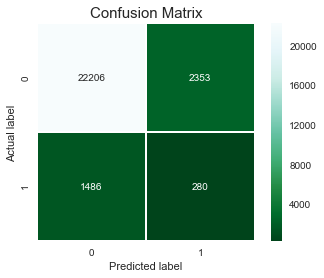

In [344]:
# Training
x = x_tr
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_tr_pred = pd.Series(y_pred)
pretty_cm(y_pred, y_tr, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.857
AUC Score: 0.527
Precision: 0.094
Recall: 0.150
F1: 0.115
Prevelance: 0.062


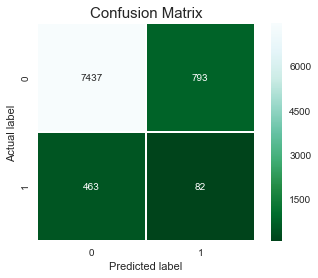

In [345]:
# Validation
x = x_v
y = y_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_v_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

In [346]:
#roc_curve(y_tr, y_tr_pred, y_v, y_v_pred)

## Parameter Optimization

### Average Precision
Ran poorly. Do not re-run.

In [371]:
# # Model
# clf = IsolationForest(random_state=rng,  behaviour="new")

# # Parameters
# param_dist = {'n_estimators':sp_randint(100,400),
#                    'max_samples': sp_randint(100,500), 
#                    'contamination': [0.01, 0.05, 0.1, 0.2], 
#                    'max_features': sp_randint(1,20), 
#                    'bootstrap': [True, False]}

# # Scorer
# scorer = 'average_precision'

# # Number of Search
# n_iter_search = n_iter_search

# # Radomizer
# random_if_estimator = RandomizedSearchCV(clf, 
#                                        param_dist,
#                                        n_iter = n_iter_search,
#                                        scoring = scorer, 
#                                        cv=5,
#                                        n_jobs = 4,
#                                        verbose = 1,
#                                        return_train_score = True)

In [372]:
# random_if_estimator.fit(x_tr, y_tr)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 25.2min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 33.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x0000021709861E10>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=50, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002177F3B1748>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002177F3B1828>,
                                      

In [373]:
# print('Scorer')
# print(random_if_estimator.scorer_)
# print("")
# print("Best Score")
# print(random_if_estimator.best_score_)
# print("")
# print("Best Score Parameters")
# print(random_if_estimator.best_params_)

Scorer
make_scorer(average_precision_score, needs_threshold=True)

Best Score
0.05495066232615143

Best Score Parameters
{'bootstrap': True, 'contamination': 0.01, 'max_features': 1, 'max_samples': 167, 'n_estimators': 102}


In [374]:
# clf_avg_pre = random_if_estimator.best_estimator_
# clf = clf_avg_pre

#######################
Evaluation metrics ####
#######################
Accuracy: 0.926
AUC Score: 0.506
Precision: 0.136
Recall: 0.020
F1: 0.035
Prevelance: 0.067


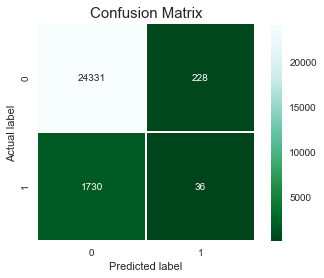

In [375]:
# # Training
# x = x_tr
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_tr_pred = pd.Series(y_pred)
# pretty_cm(y_pred, y_tr, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.929
AUC Score: 0.507
Precision: 0.130
Recall: 0.024
F1: 0.040
Prevelance: 0.062


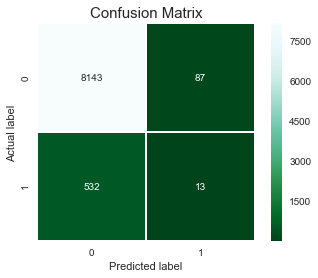

In [376]:
# # Validation
# x = x_v
# y = y_v
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_v_pred = pd.Series(y_pred)

# pretty_cm(y_pred, y, [0, 1])

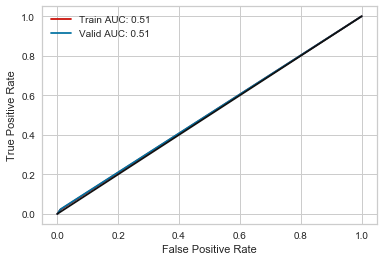

In [377]:
# roc_curve_plot(y_tr, y_tr_pred, y_v, y_v_pred)

### Balanced Accuracy
Do Not Run. Was Generating Batches with Zero Positives

In [380]:
# # Model
# clf = IsolationForest(random_state=rng,  behaviour="new")

# # Parameters
# param_dist = {'n_estimators':sp_randint(100,400),
#                    'max_samples': sp_randint(100,500), 
#                    'contamination': [0.01, 0.05, 0.1, 0.2], 
#                    'max_features': sp_randint(1,20), 
#                    'bootstrap': [True, False]}

# # Scorer
# scorer = 'balanced_accuracy'

# # Number of Search
# n_iter_search = n_iter_search

# # Radomizer
# random_if_estimator = RandomizedSearchCV(clf, 
#                                        param_dist,
#                                        n_iter = n_iter_search,
#                                        scoring = scorer, 
#                                        cv=5,
#                                        #n_jobs = -1,
#                                        verbose = 1,
#                                        return_train_score = True)

In [ ]:
#random_if_estimator.fit(x_tr, y_tr)

In [ ]:
# print('Scorer')
# print(random_if_estimator.scorer_)
# print("")
# print("Best Score")
# print(random_if_estimator.best_score_)
# print("")
# print("Best Score Parameters")
# print(random_if_estimator.best_params_)

In [ ]:
# clf_bal_acc = random_if_estimator.best_estimator_
# clf = clf_bal_acc

In [ ]:
# # Training
# x = x_tr
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_tr_pred = pd.Series(y_pred)
# pretty_cm(y_pred, y_tr, [0, 1])

In [ ]:
# # Validation
# x = x_v
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_v_pred = pd.Series(y_pred)

# pretty_cm(y_pred, y, [0, 1])

In [ ]:
# roc_curve_plot(y_tr, y_tr_pred, y_v, y_v_pred)

### AUC Score
Best Tuning Metric so far.

In [385]:
# Model
clf = IsolationForest(random_state=rng,  behaviour="new")

# Parameters
param_dist = {'n_estimators':sp_randint(100,400),
                   'max_samples': sp_randint(100,500), 
                   'contamination': [0.01, 0.05, 0.1, 0.2], 
                   'max_features': sp_randint(1,20), 
                   'bootstrap': [True, False]}

# Scorer
scorer = 'roc_auc'

# Number of Search
n_iter_search = n_iter_search

# Radomizer
random_if_estimator = RandomizedSearchCV(clf, 
                                       param_dist,
                                       n_iter = n_iter_search,
                                       scoring = scorer, 
                                       cv=5,
                                       n_jobs = 4,
                                       verbose = 1,
                                       return_train_score = True)

In [386]:
random_if_estimator.fit(x_tr, y_tr)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 19.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x0000021709861E10>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021748239F98>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021709947FD0>,
                                      

In [387]:
print('Scorer')
print(random_if_estimator.scorer_)
print("")
print("Best Score")
print(random_if_estimator.best_score_)
print("")
print("Best Score Parameters")
print(random_if_estimator.best_params_)

Scorer
make_scorer(roc_auc_score, needs_threshold=True)

Best Score
0.4157943337639521

Best Score Parameters
{'bootstrap': False, 'contamination': 0.05, 'max_features': 11, 'max_samples': 440, 'n_estimators': 154}


In [388]:
clf_auc = random_if_estimator.best_estimator_
clf = clf_auc

#######################
Evaluation metrics ####
#######################
Accuracy: 0.894
AUC Score: 0.519
Precision: 0.114
Recall: 0.085
F1: 0.097
Prevelance: 0.067


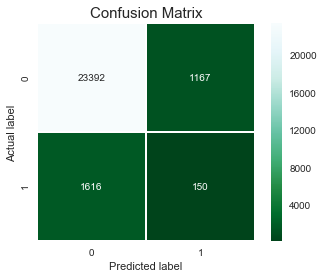

In [389]:
# Training
x = x_tr
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_tr_pred = pd.Series(y_pred)
pretty_cm(y_pred, y_tr, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.897
AUC Score: 0.516
Precision: 0.098
Recall: 0.081
F1: 0.088
Prevelance: 0.062


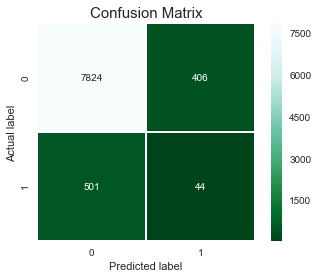

In [390]:
# Validation
x = x_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_v_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

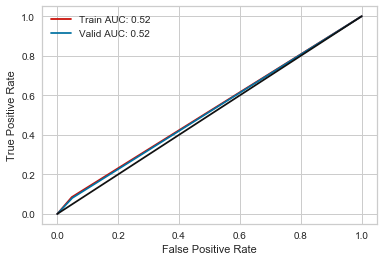

In [391]:
roc_curve_plot(y_tr, y_tr_pred, y_v, y_v_pred)

### F1 Weighted
Ran once and performed poorly. Do not run again.

In [394]:
# # Model
# clf = IsolationForest(random_state=rng,  behaviour="new")

# # Parameters
# param_dist = {'n_estimators':sp_randint(100,400),
#                    'max_samples': sp_randint(100,500), 
#                    'contamination': [0.01, 0.05, 0.1, 0.2], 
#                    'max_features': sp_randint(1,20), 
#                    'bootstrap': [True, False]}

# # Scorer
# scorer = 'f1_weighted'

# # Number of Search
# n_iter_search = n_iter_search

# # Radomizer
# random_if_estimator = RandomizedSearchCV(clf, 
#                                        param_dist,
#                                        n_iter = n_iter_search,
#                                        scoring = scorer, 
#                                        cv=5,
#                                        n_jobs = 4,
#                                        verbose = 1,
#                                        return_train_score = True)

In [395]:
# random_if_estimator.fit(x_tr, y_tr)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 17.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x0000021709861E10>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002170E323940>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002170E323B70>,
                                      

In [ ]:
# print('Scorer')
# print(random_if_estimator.scorer_)
# print("")
# print("Best Score")
# print(random_if_estimator.best_score_)
# print("")
# print("Best Score Parameters")
# print(random_if_estimator.best_params_)

In [396]:
# clf_f1 = random_if_estimator.best_estimator_
# clf = clf_f1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.925
AUC Score: 0.505
Precision: 0.125
Precision Weighted: 0.879
Recall: 0.019
Recall Weighted: 0.925
F1: 0.033
F1 Weighted: 0.899
Prevelance: 0.067


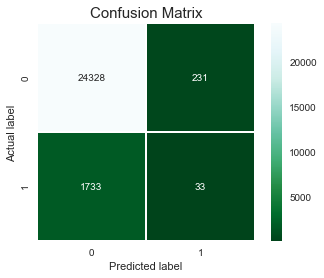

In [405]:
# # Training
# x = x_tr
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_tr_pred = pd.Series(y_pred)
# pretty_cm(y_pred, y_tr, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.930
AUC Score: 0.505
Precision: 0.121
Precision Weighted: 0.888
Recall: 0.020
Recall Weighted: 0.930
F1: 0.035
F1 Weighted: 0.906
Prevelance: 0.062


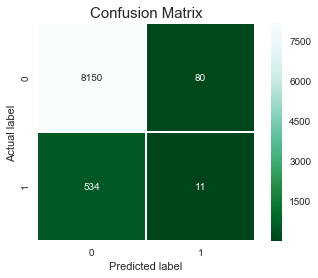

In [406]:
# # Validation
# x = x_v
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_v_pred = pd.Series(y_pred)

# pretty_cm(y_pred, y, [0, 1])

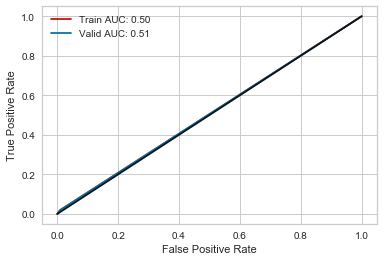

In [403]:
# roc_curve_plot(y_tr, y_tr_pred, y_v, y_v_pred)

### Precision Weighted
Ran once and scored very poorly. Do not run again.

In [411]:
# # Model
# clf = IsolationForest(random_state=rng,  behaviour="new")

# # Parameters
# param_dist = {'n_estimators':sp_randint(100,400),
#                    'max_samples': sp_randint(100,500), 
#                    'contamination': [0.01, 0.05, 0.1, 0.2], 
#                    'max_features': sp_randint(1,20), 
#                    'bootstrap': [True, False]}

# # Scorer
# scorer = 'precision_weighted'

# # Number of Search
# n_iter_search = n_iter_search

# # Radomizer
# random_if_estimator = RandomizedSearchCV(clf, 
#                                        param_dist,
#                                        n_iter = n_iter_search,
#                                        scoring = scorer, 
#                                        cv=5,
#                                        n_jobs = 4,
#                                        verbose = 1,
#                                        return_train_score = True)

In [412]:
#random_if_estimator.fit(x_tr, y_tr)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 15.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x000002170CCB2048>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021749A6B320>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021749A6B6A0>,
                                      

In [413]:
# print('Scorer')
# print(random_if_estimator.scorer_)
# print("")
# print("Best Score")
# print(random_if_estimator.best_score_)
# print("")
# print("Best Score Parameters")
# print(random_if_estimator.best_params_)

Scorer
make_scorer(precision_score, pos_label=None, average=weighted)

Best Score
0.004476010188541674

Best Score Parameters
{'bootstrap': False, 'contamination': 0.01, 'max_features': 12, 'max_samples': 313, 'n_estimators': 124}


In [415]:
# clf_pre = random_if_estimator.best_estimator_
# clf = clf_pre

#######################
Evaluation metrics ####
#######################
Accuracy: 0.925
AUC Score: 0.504
Precision: 0.121
Precision Weighted: 0.879
Recall: 0.018
Recall Weighted: 0.925
F1: 0.032
F1 Weighted: 0.899
Prevelance: 0.067


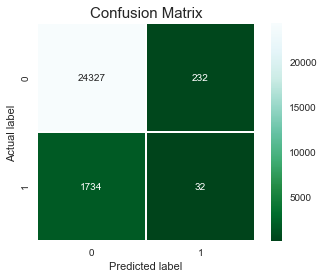

In [416]:
# # Training
# x = x_tr
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_tr_pred = pd.Series(y_pred)
# pretty_cm(y_pred, y_tr, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.930
AUC Score: 0.504
Precision: 0.111
Precision Weighted: 0.887
Recall: 0.018
Recall Weighted: 0.930
F1: 0.031
F1 Weighted: 0.906
Prevelance: 0.062


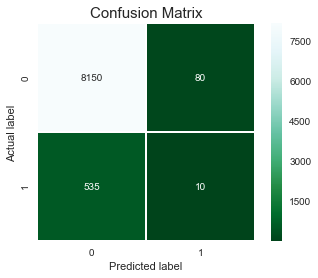

In [417]:
# # Validation
# x = x_v
# y_pred = clf.predict(x)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_v_pred = pd.Series(y_pred)

# pretty_cm(y_pred, y, [0, 1])

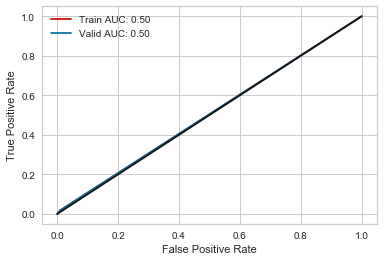

In [418]:
#roc_curve_plot(y_tr, y_tr_pred, y_v, y_v_pred)

# Test Set Scoring

## General Function

In [423]:
def test_score(clf, x):
    
    print("Detailed classification report:")
    print()
    print("The model is trained and tuned on the training and validation sets..")
    print("The scores are computed on the test set.")
    print()
    y_true, y_pred = y_te, clf.predict(x)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(classification_report(y_true, y_pred, digits = 3))
    print()
    
    prevalence_te = '%.3f' %calc_prevalence(y_true)
    auc_score_te = '%.3f' %roc_auc_score(y_true, y_pred)
    print('AUC Score: ', auc_score_te)
    print('Positive Target Prevalence: ', prevalence_te)
    

In [420]:
def test_score_cv(clf, x):
    scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
    
    results = cross_validate(estimator = clf,
                                          X = x,
                                          y = y_te,
                                          cv = 5,
                                          scoring = scoring)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %.3f' % (metric_name, average_score))
    
    prevalence_te = '%.3f' %calc_prevalence(y_te)
    print('positive target prevalence: ', prevalence_te)

## Isolation Forest

#######################
Evaluation metrics ####
#######################
Accuracy: 0.894
AUC Score: 0.518
Precision: 0.114
Precision Weighted: 0.879
Recall: 0.084
Recall Weighted: 0.894
F1: 0.097
F1 Weighted: 0.886
Prevelance: 0.068


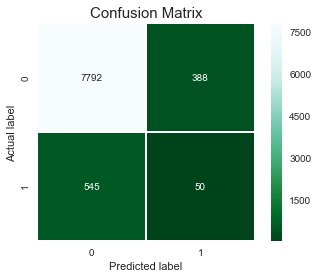

In [426]:
clf = clf_auc

# Test
x = x_te
y = y_te
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_v_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

In [425]:
#test_score_cv(clf_auc, x_te)